In [28]:
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model

Using TensorFlow backend.


In [30]:
THRESH_WOOD = 0.15
THRESH_WATER = 0.15
THRESH_PEAK = 0.08

## Загружаем одну картинку и получаем маску

In [2]:
with open('../dataset/train_val_test_split.pickle', 'rb') as f:
    train_val_test = pickle.load(f)
    
train_filenames = train_val_test['train']
validate_filenames = train_val_test['validate']
test_filenames = train_val_test['test']

In [3]:
maps_folder = '../dataset/map/'
satellites_folder = '../dataset/satellite/'
masks_folder = '../dataset/masks/'

In [18]:
def load_data(filename):
    satellite_img = cv2.imread(os.path.join(satellites_folder, filename + '.png'))
    masks = np.load(os.path.join(masks_folder, filename + '.npy'))
    
    return satellite_img, masks

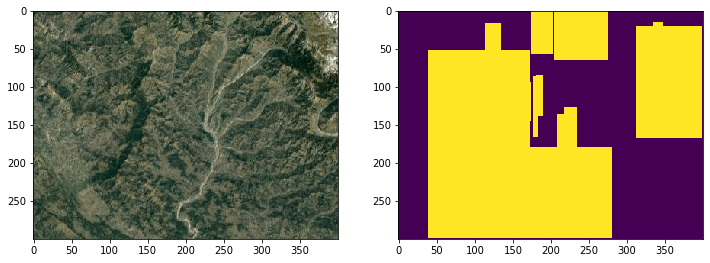

In [26]:
satellite_img, masks = load_data(train_filenames[2])


plt.figure(figsize=(12, 15))

plt.subplot(121)
plt.imshow(cv2.cvtColor(satellite_img, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.imshow(masks[0])

plt.show()

In [ ]:
# {0: 'wood', 1: 'water', 2: 'valley', 3: 'peak', 4: 'ridge'}

In [29]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [35]:
mask_pred = autoencoder.predict(np.array([satellite_img / 255.]).reshape(([1] + list(satellite_img.shape))))[0] >= THRESH_WOOD

In [39]:
def predict_one(autoencoder, img, thresh):
    return autoencoder.predict(np.array([img / 255.]).reshape(([1] + list(img.shape))))[0] >= thresh

In [40]:
mask_pred = predict_one(autoencoder, satellite_img, THRESH_WOOD)

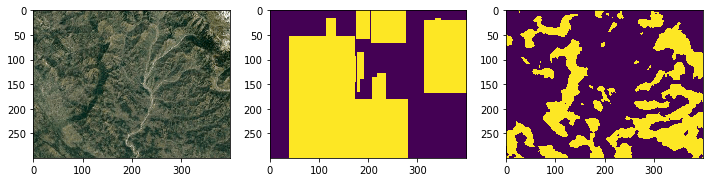

In [41]:
plt.figure(figsize=(12, 15))

plt.subplot(131)
plt.imshow(cv2.cvtColor(satellite_img, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.imshow(masks[0])

plt.subplot(133)
plt.imshow(mask_pred.reshape(satellite_img.shape[:2]))

plt.show()

In [42]:
mask_pred

array([[[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

## Алгоритм преобразования масок в прямоугольники

Каждая вершина - пиксель.

Между любыми 2мя соседними покрашенными пикселями есть ребро.

BFS.

Рассматриваем первую непосещённую вершину.

В процессе сохраняем min_x, max_x, min_y, max_y.

Нужно хранить: 
    - матрица того, посещена вершина или нет
    - очередь вершин (x, y)

In [188]:
def mask_to_rectangles(mask):
    visited = np.zeros(mask.shape[:2], dtype=int)
    queue = []
    rectangles = []
    
    queue_idx = 0

    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            # первая непосещённая вершина
            if visited[x][y] == 0 and mask[x][y]:
                cur_vertex = (x, y)
            else:
                continue
        
            queue.append(cur_vertex)
        
            def bfs(queue_idx):
                min_x, max_x, min_y, max_y = None, None, None, None

                while len(queue) != queue_idx:
                    v = queue[queue_idx]
                    queue_idx += 1

                    x, y = v
                    if visited[x][y] == 1:
                        continue
                    visited[x][y] = 1

                    if min_x is None or x < min_x:
                        min_x = x
                    if max_x is None or x > max_x:
                        max_x = x
                    if min_y is None or y < min_y:
                        min_y = y
                    if max_y is None or y > max_y:
                        max_y = y

                    # рассматриваем все соседние непосещённые вершины
                    left = (x, y - 1)
                    right = (x, y + 1)
                    top = (x - 1, y)
                    bottom = (x + 1, y)

                    def visit_vertex(x, y):
                        if x >= 0 and y >= 0 and x < mask.shape[0] and y < mask.shape[1] and visited[x][y] == 0\
                            and mask[x][y]:
                                queue.append((x, y))

                    visit_vertex(*left)
                    visit_vertex(*right)
                    visit_vertex(*top)
                    visit_vertex(*bottom)

                return queue_idx, queue, visited, min_x, max_x, min_y, max_y

            queue_idx, queue, visited, min_x, max_x, min_y, max_y = bfs(queue_idx)
            if min_x is not None and max_x is not None and min_y is not None and max_y is not None:
                rectangles.append((min_x, max_x, min_y, max_y))

    return rectangles


In [189]:
%%time
rectangles = mask_to_rectangles(mask_pred)

CPU times: user 279 ms, sys: 0 ns, total: 279 ms
Wall time: 278 ms


In [190]:
def get_result_mask(mask_pred, rectangles):
    res_mask = np.zeros((mask_pred.shape[0], mask_pred.shape[1])).astype(np.int8)
    
    for bbox in rectangles:
        x1, x2, y1, y2 = bbox
        res_mask[x1:x2, y1:y2] = np.array([1 for _ in range((x2 - x1) * (y2 - y1))]).reshape((x2 - x1, y2 - y1))
        
    return res_mask

In [191]:
res_mask = get_result_mask(mask_pred, rectangles)

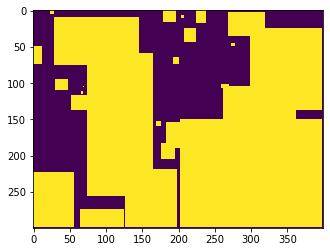

In [192]:
plt.imshow(res_mask)

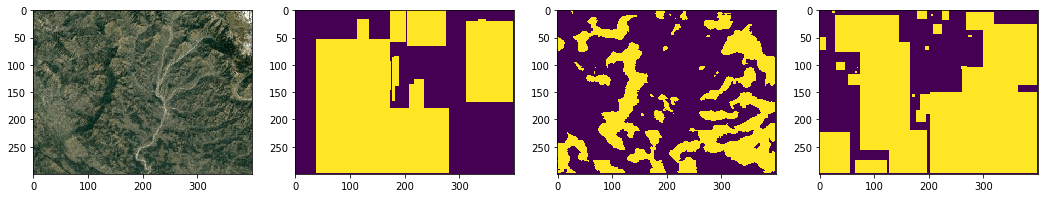

In [193]:
plt.figure(figsize=(18, 20))

plt.subplot(141)
plt.imshow(cv2.cvtColor(satellite_img, cv2.COLOR_BGR2RGB))

plt.subplot(142)
plt.imshow(masks[0])

plt.subplot(143)
plt.imshow(mask_pred.reshape(satellite_img.shape[:2]))

plt.subplot(144)
plt.imshow(res_mask)

plt.show()

In [194]:
rectangles

[(0, 0, 0, 0),
 (0, 6, 23, 29),
 (0, 16, 179, 197),
 (0, 18, 225, 238),
 (0, 0, 297, 297),
 (0, 0, 299, 301),
 (3, 36, 269, 320),
 (7, 11, 204, 208),
 (9, 76, 29, 146),
 (15, 15, 215, 216),
 (25, 44, 208, 225),
 (25, 138, 299, 398),
 (39, 39, 355, 355),
 (45, 49, 273, 279),
 (49, 74, 0, 13),
 (59, 256, 75, 166),
 (65, 74, 193, 201),
 (95, 110, 31, 48),
 (95, 95, 347, 347),
 (102, 108, 259, 270),
 (104, 106, 69, 71),
 (105, 165, 262, 363),
 (112, 116, 66, 69),
 (112, 116, 291, 294),
 (117, 138, 53, 97),
 (118, 121, 286, 289),
 (138, 138, 380, 380),
 (150, 298, 203, 398),
 (153, 159, 169, 176),
 (154, 190, 184, 212),
 (159, 173, 206, 221),
 (167, 167, 222, 222),
 (183, 205, 177, 196),
 (183, 202, 260, 331),
 (189, 192, 153, 157),
 (206, 207, 310, 311),
 (215, 222, 242, 254),
 (219, 298, 127, 198),
 (223, 298, 0, 57),
 (274, 298, 65, 125),
 (275, 278, 0, 0),
 (286, 286, 65, 65),
 (295, 295, 398, 398),
 (297, 297, 9, 9),
 (298, 298, 398, 398)]

## Примеры

### wood examples

In [216]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))

In [304]:
def test_one(autoencoder, idx, thresh=THRESH_WOOD):
    satellite_img, masks = load_data(train_filenames[idx])

    wood_original_mask = masks[0]
    water_original_mask = masks[1]
    peak_original_mask = masks[3]

    mask_pred = predict_one(autoencoder, satellite_img, thresh)
    
    rectangles = mask_to_rectangles(mask_pred)
    
    res_mask = get_result_mask(mask_pred, rectangles)
    
    plt.figure(figsize=(18, 20))

    plt.subplot(141)
    plt.title('Original image')
    plt.imshow(cv2.cvtColor(satellite_img, cv2.COLOR_BGR2RGB))
    plt.subplot(142)
    plt.title('Wood original mask')
    plt.imshow(wood_original_mask)
    plt.subplot(143)
    plt.title('Water original mask')
    plt.imshow(water_original_mask)
    plt.subplot(144)
    plt.title('Peak original mask')
    plt.imshow(peak_original_mask)
    plt.show()
    
    plt.figure(figsize=(10, 12))
    plt.subplot(121)
    plt.title('Predicted mask')
    plt.imshow(mask_pred.reshape((mask_pred.shape[0], mask_pred.shape[1])))
    plt.subplot(122)
    plt.title('Result rectangles mask')
    plt.imshow(res_mask)
    plt.show()

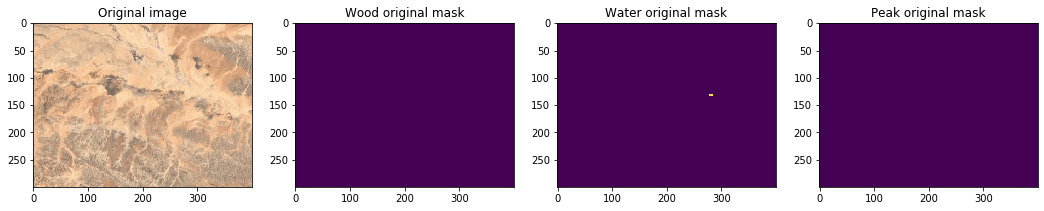

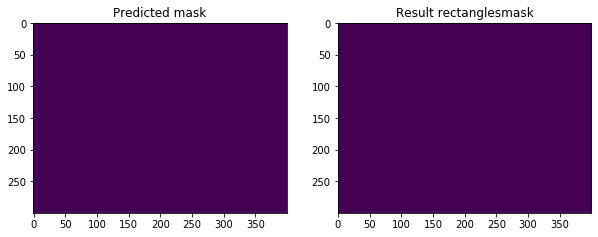

CPU times: user 1.35 s, sys: 11.8 ms, total: 1.37 s
Wall time: 1.13 s


In [241]:
%%time
test_one(autoencoder, 7)

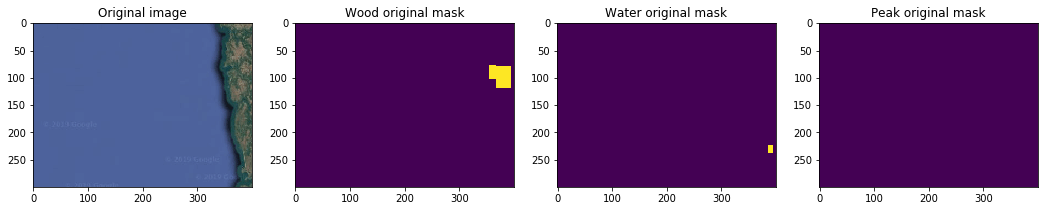

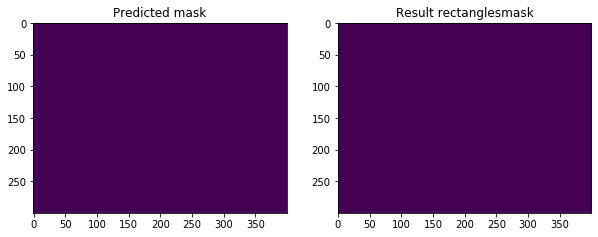

CPU times: user 1.19 s, sys: 7.67 ms, total: 1.19 s
Wall time: 978 ms


In [242]:
%%time
test_one(autoencoder, 16)

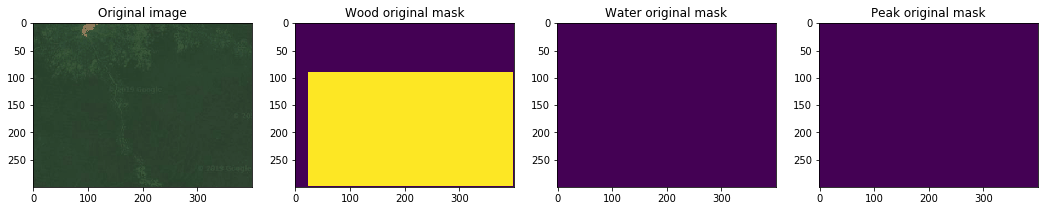

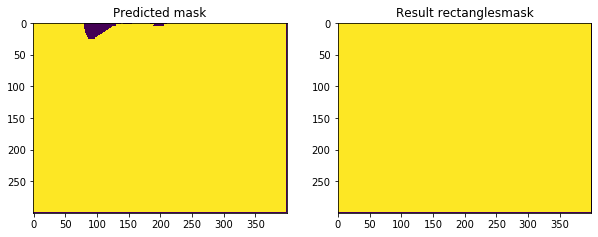

CPU times: user 2 s, sys: 24.4 ms, total: 2.03 s
Wall time: 1.81 s


In [244]:
%%time
test_one(autoencoder, 18)

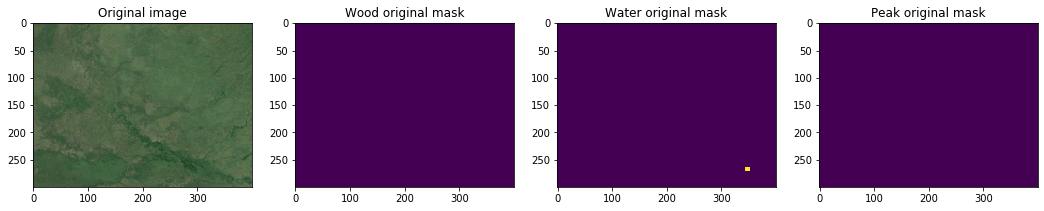

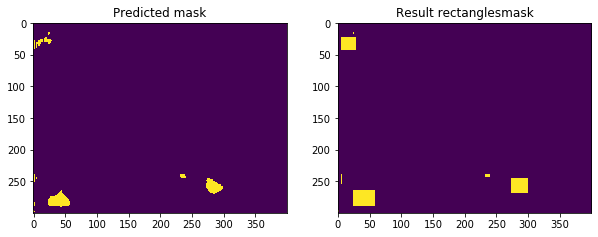

CPU times: user 1.57 s, sys: 11.6 ms, total: 1.58 s
Wall time: 1.36 s


In [245]:
%%time
test_one(autoencoder, 19)

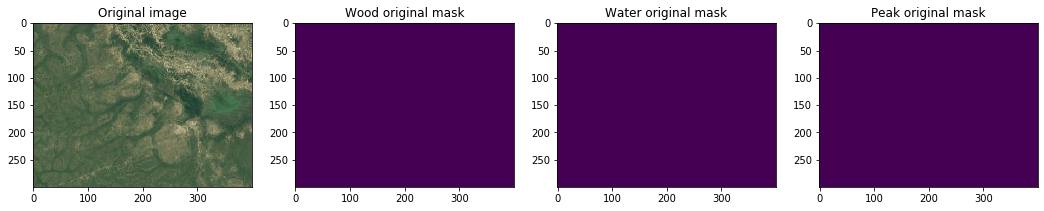

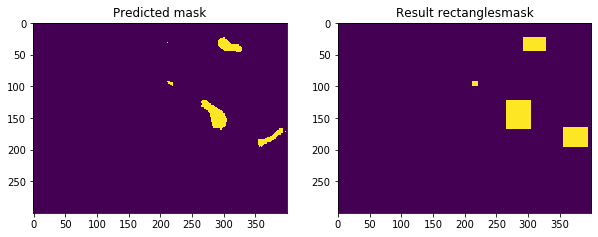

CPU times: user 1.28 s, sys: 12 ms, total: 1.29 s
Wall time: 1.07 s


In [246]:
%%time
test_one(autoencoder, 20)

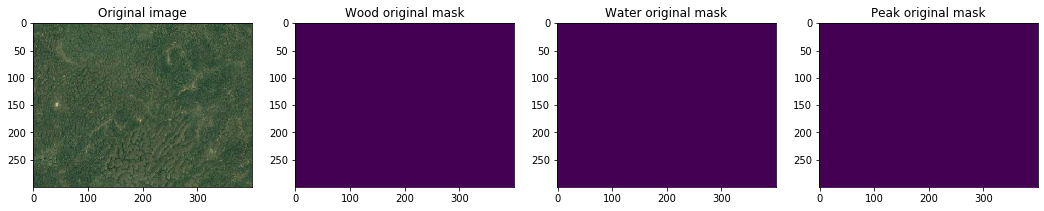

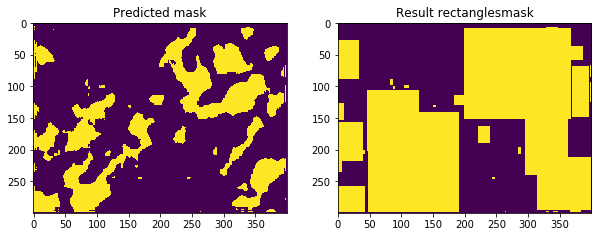

CPU times: user 1.42 s, sys: 9.4 ms, total: 1.43 s
Wall time: 1.2 s


In [249]:
%%time
test_one(autoencoder, 23)

### water examples

In [250]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_water_satellite.h5'))

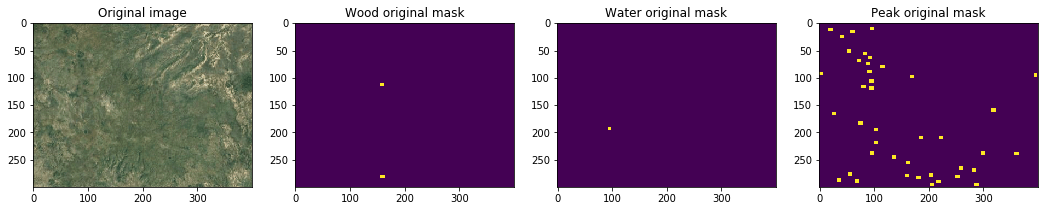

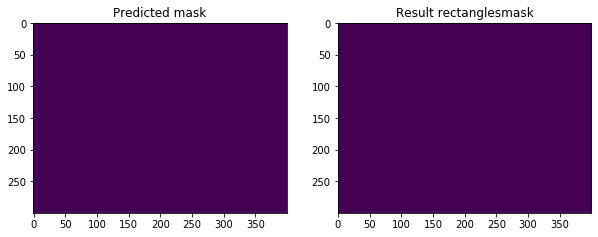

CPU times: user 1.4 s, sys: 23.7 ms, total: 1.42 s
Wall time: 1.18 s


In [251]:
%%time
test_one(autoencoder, 0)

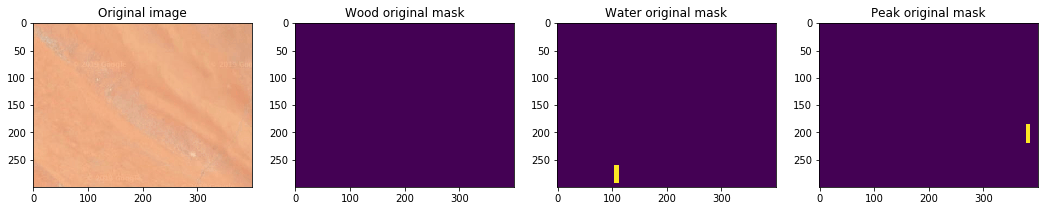

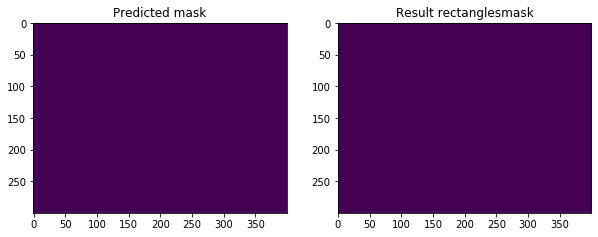

CPU times: user 1.26 s, sys: 15.7 ms, total: 1.28 s
Wall time: 1.04 s


In [252]:
%%time
test_one(autoencoder, 1)

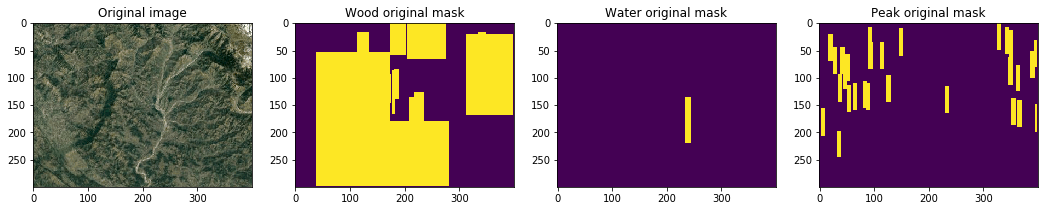

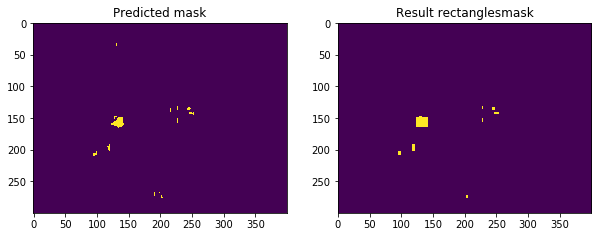

CPU times: user 1.28 s, sys: 7.61 ms, total: 1.29 s
Wall time: 1.05 s


In [253]:
%%time
test_one(autoencoder, 2)

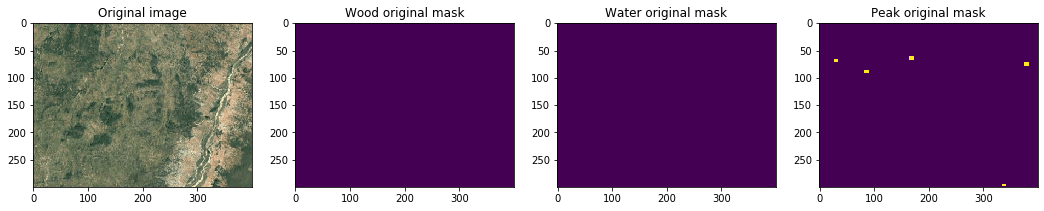

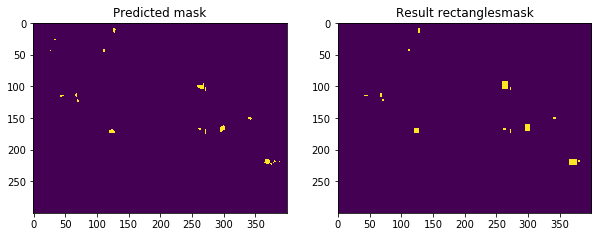

CPU times: user 1.52 s, sys: 23.7 ms, total: 1.54 s
Wall time: 1.34 s


In [254]:
%%time
test_one(autoencoder, 3)

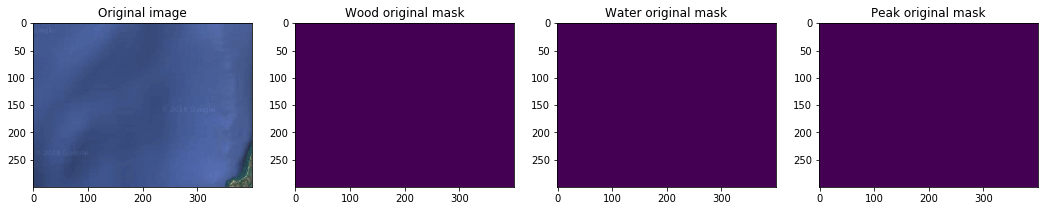

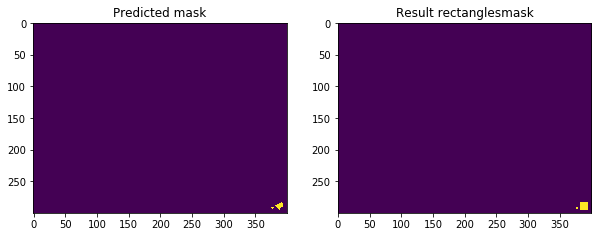

CPU times: user 1.21 s, sys: 12 ms, total: 1.23 s
Wall time: 990 ms


In [258]:
%%time
test_one(autoencoder, 6)

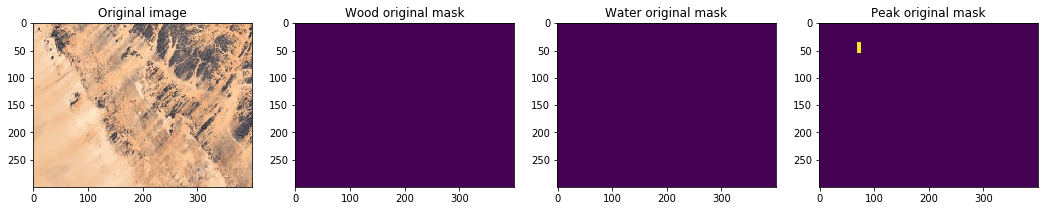

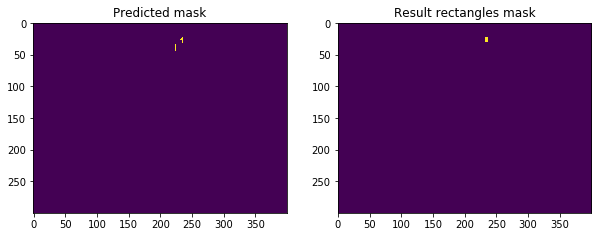

CPU times: user 1.32 s, sys: 20 ms, total: 1.34 s
Wall time: 1.11 s


In [265]:
%%time
test_one(autoencoder, 11)

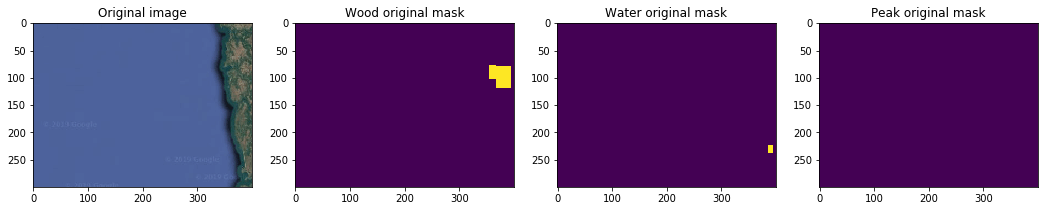

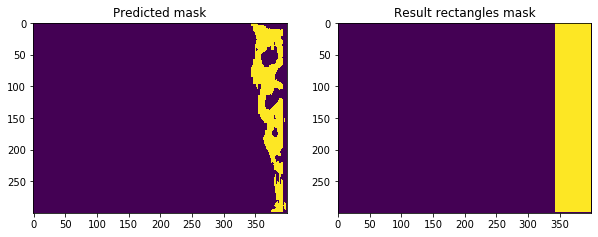

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.14 s


In [272]:
%%time
test_one(autoencoder, 16)

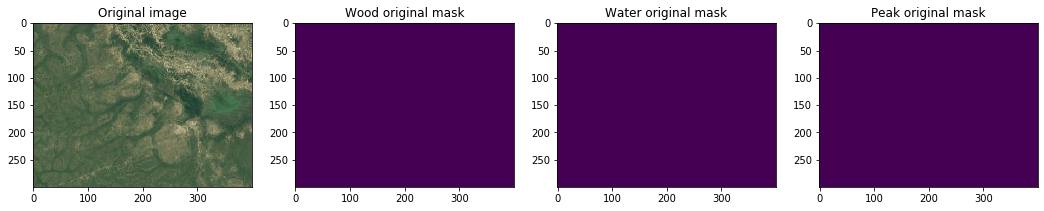

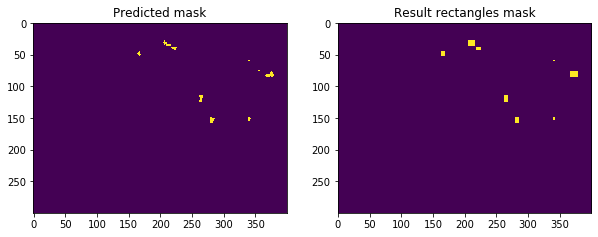

CPU times: user 1.27 s, sys: 3.8 ms, total: 1.27 s
Wall time: 1.04 s


In [276]:
%%time
test_one(autoencoder, 20)

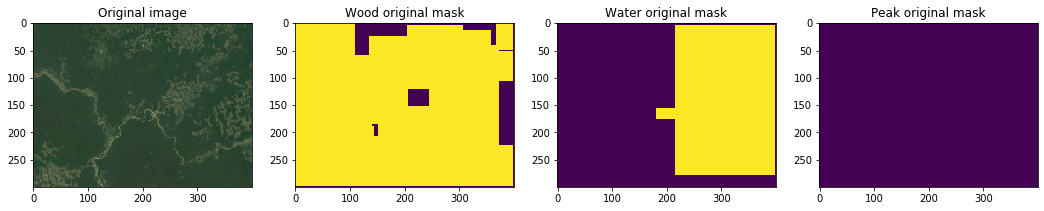

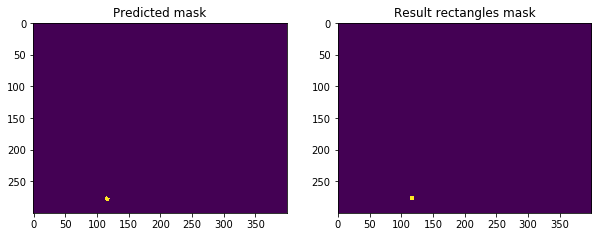

CPU times: user 1.34 s, sys: 7.71 ms, total: 1.35 s
Wall time: 1.12 s


In [281]:
%%time
test_one(autoencoder, 24)

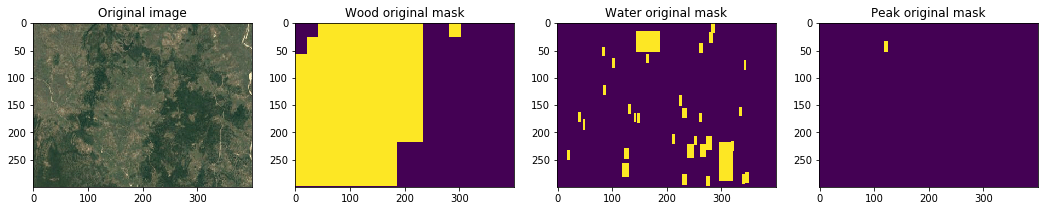

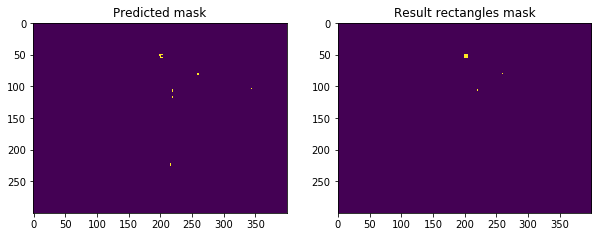

CPU times: user 1.37 s, sys: 11.6 ms, total: 1.38 s
Wall time: 1.16 s


In [282]:
%%time
test_one(autoencoder, 25)

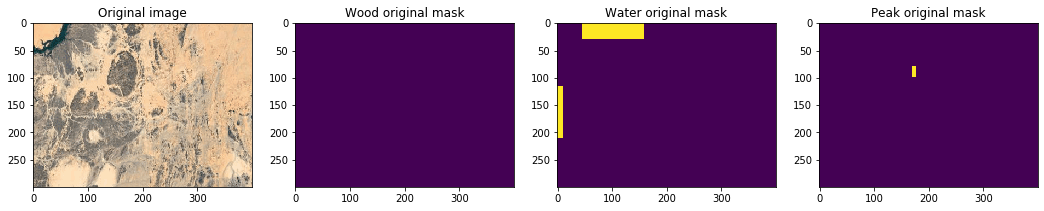

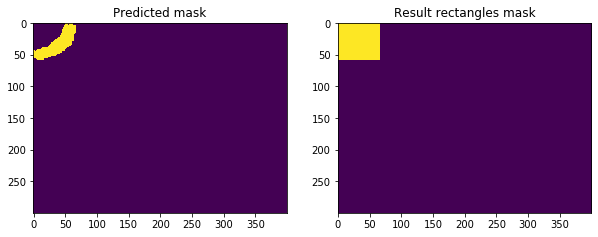

CPU times: user 1.25 s, sys: 7.6 ms, total: 1.26 s
Wall time: 1.03 s


In [291]:
%%time
test_one(autoencoder, 34)

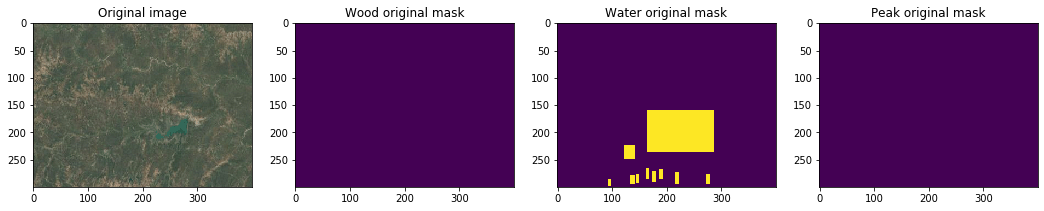

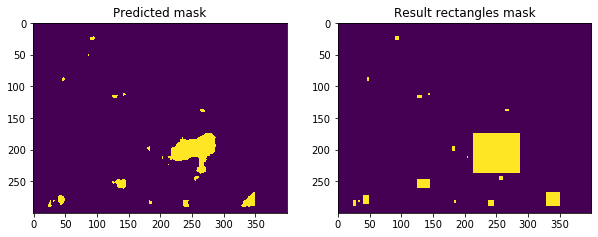

CPU times: user 1.22 s, sys: 15.8 ms, total: 1.24 s
Wall time: 1.03 s


In [295]:
%%time
test_one(autoencoder, 38)

### peak

In [297]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_peak_satellite.h5'))

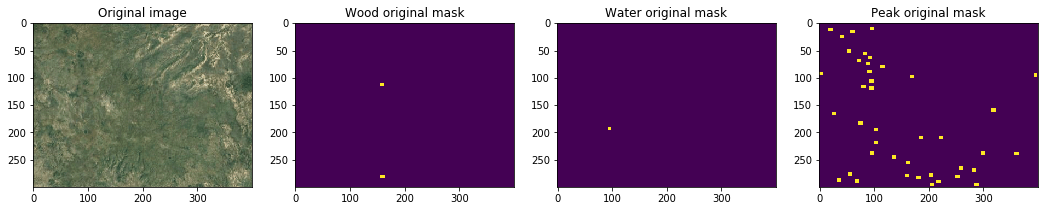

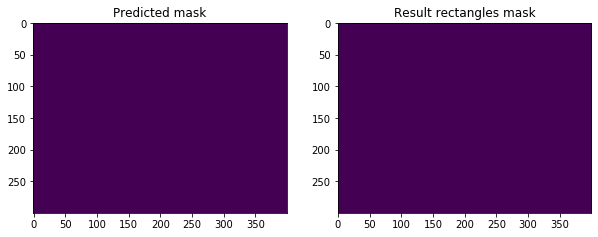

CPU times: user 1.27 s, sys: 11.8 ms, total: 1.28 s
Wall time: 1.05 s


In [305]:
%%time
test_one(autoencoder, 0, thresh=THRESH_PEAK)

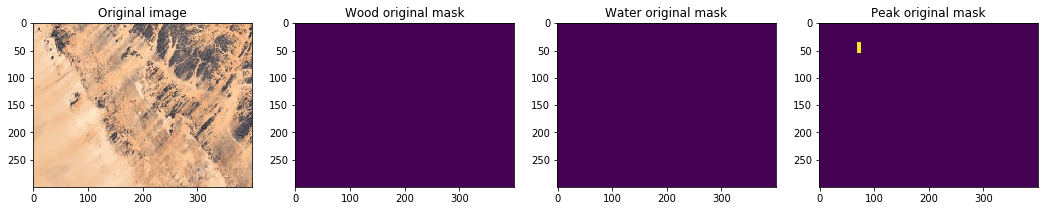

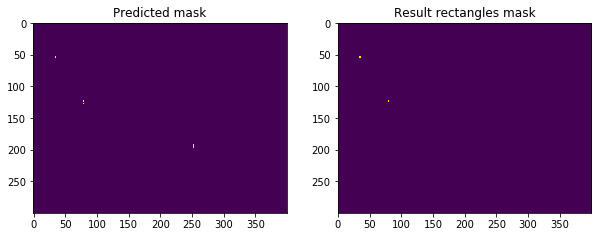

CPU times: user 1.22 s, sys: 23.8 ms, total: 1.24 s
Wall time: 1 s


In [316]:
%%time
test_one(autoencoder, 11, thresh=THRESH_PEAK)

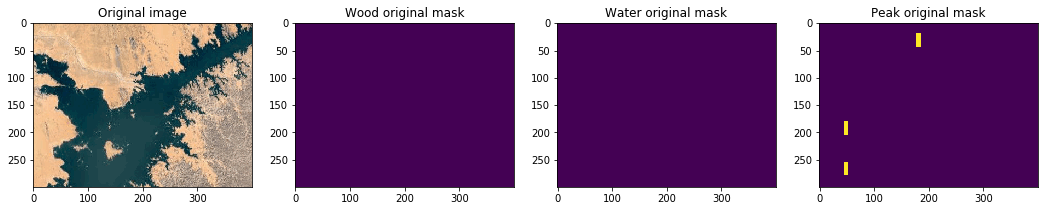

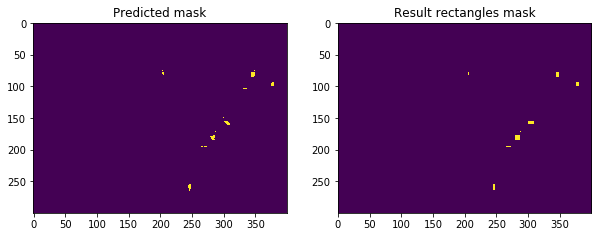

CPU times: user 1.34 s, sys: 24.1 ms, total: 1.37 s
Wall time: 1.14 s


In [345]:
%%time
test_one(autoencoder, 40, thresh=THRESH_PEAK)

In [348]:
interesting_one = [2, 20, 24, 25, 34, 38, 40]

In [347]:
def full_test(idx):
    satellite_img, masks = load_data(train_filenames[idx])
    
    wood_original_mask = masks[0]
    water_original_mask = masks[1]
    peak_original_mask = masks[3]
    
    autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))
    mask_pred_wood = predict_one(autoencoder, satellite_img, THRESH_WOOD)
    rectangles_wood = mask_to_rectangles(mask_pred_wood)
    res_wood_mask = get_result_mask(mask_pred_wood, rectangles_wood)
    
    autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_water_satellite.h5'))
    mask_pred_water = predict_one(autoencoder, satellite_img, THRESH_WATER)
    rectangles_water = mask_to_rectangles(mask_pred_water)
    res_water_mask = get_result_mask(mask_pred_water, rectangles_water)
    
    autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_peak_satellite.h5'))
    mask_pred_peak = predict_one(autoencoder, satellite_img, THRESH_PEAK)
    rectangles_peak = mask_to_rectangles(mask_pred_peak)
    res_peak_mask = get_result_mask(mask_pred_peak, rectangles_peak)
    
    plt.figure(figsize=(18, 20))

    plt.subplot(141)
    plt.title('Original image')
    plt.imshow(cv2.cvtColor(satellite_img, cv2.COLOR_BGR2RGB))
    plt.subplot(142)
    plt.title('Wood original mask')
    plt.imshow(wood_original_mask)
    plt.subplot(143)
    plt.title('Water original mask')
    plt.imshow(water_original_mask)
    plt.subplot(144)
    plt.title('Peak original mask')
    plt.imshow(peak_original_mask)
    plt.show()
    
    plt.figure(figsize=(18, 20))
    
    plt.subplot(161)
    plt.title('Predicted mask WOOD')
    plt.imshow(mask_pred_wood.reshape((300, 400)))
    plt.subplot(162)
    plt.title('Result rectangles mask WOOD')
    plt.imshow(res_wood_mask)
    
    plt.subplot(163)
    plt.title('Predicted mask WATER')
    plt.imshow(mask_pred_water.reshape((300, 400)))
    plt.subplot(164)
    plt.title('Result rectangles mask WATER')
    plt.imshow(res_water_mask)
    
    plt.subplot(165)
    plt.title('Predicted mask PEAK')
    plt.imshow(mask_pred_peak.reshape((300, 400)))
    plt.subplot(166)
    plt.title('Result rectangles mask PEAK')
    plt.imshow(res_peak_mask)
    
    plt.show()

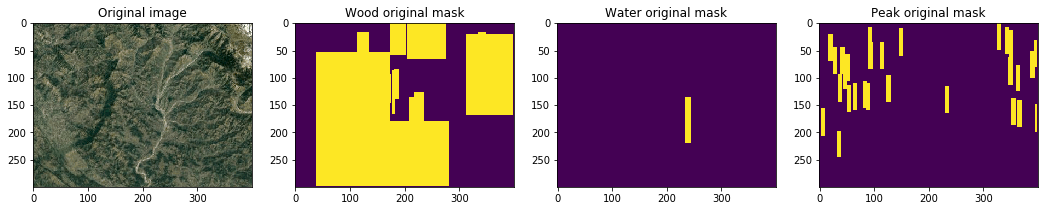

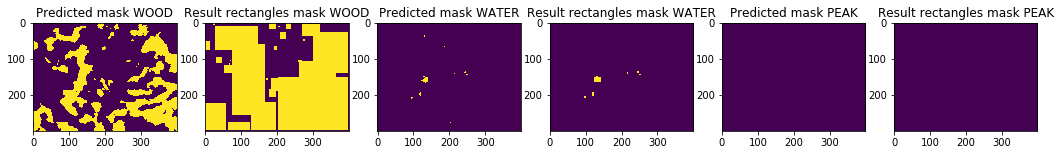

CPU times: user 10 s, sys: 77.9 ms, total: 10.1 s
Wall time: 9.42 s


In [350]:
%%time
full_test(interesting_one[0])

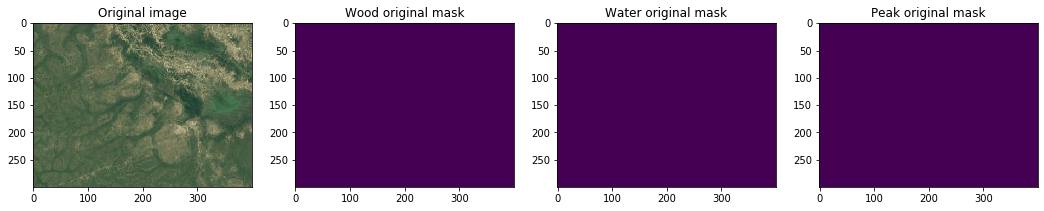

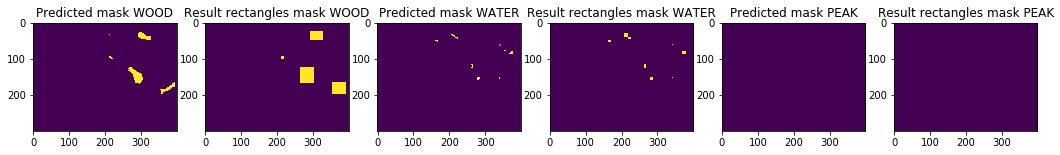

CPU times: user 12.5 s, sys: 49.1 ms, total: 12.5 s
Wall time: 11.9 s


In [351]:
%%time
full_test(interesting_one[1])

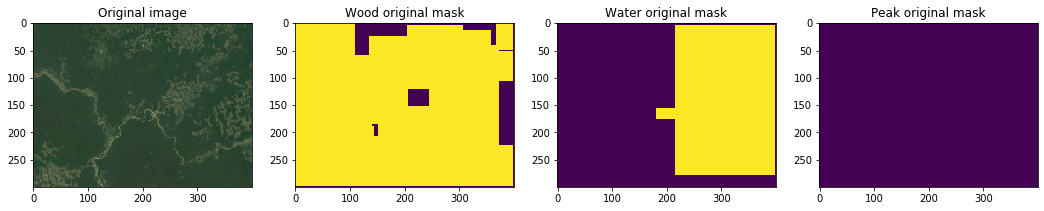

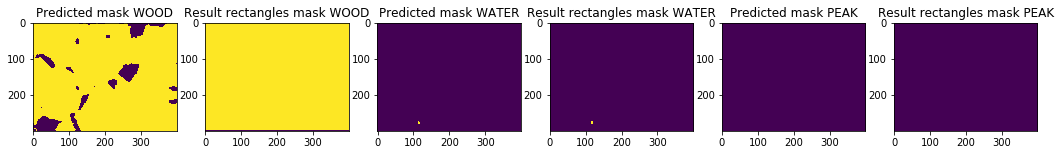

CPU times: user 15 s, sys: 56.8 ms, total: 15 s
Wall time: 14.4 s


In [352]:
%%time
full_test(interesting_one[2])

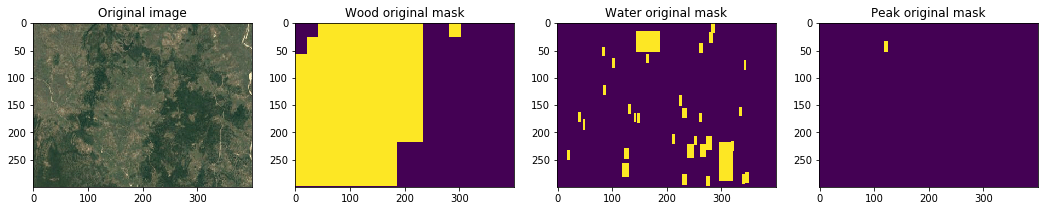

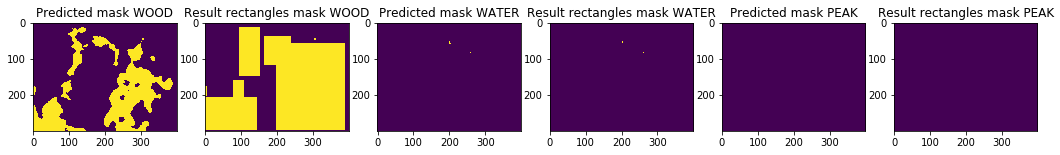

CPU times: user 16.5 s, sys: 92.8 ms, total: 16.6 s
Wall time: 15.9 s


In [353]:
%%time
full_test(interesting_one[3])

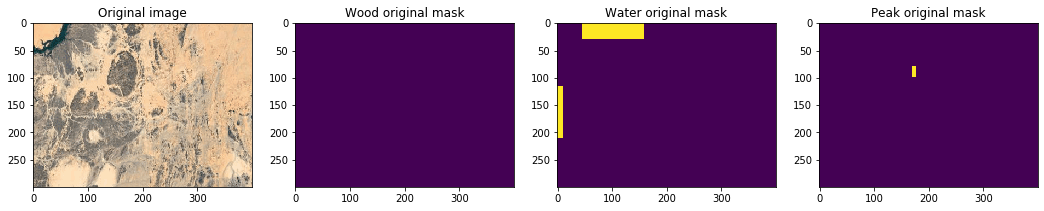

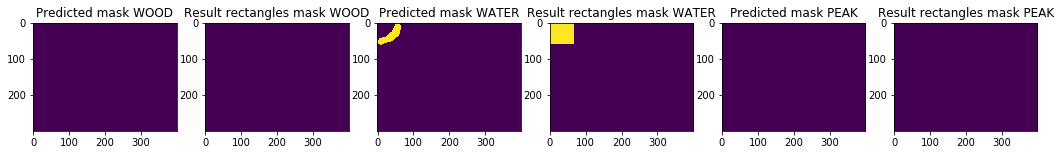

CPU times: user 18.5 s, sys: 79.4 ms, total: 18.6 s
Wall time: 17.9 s


In [354]:
%%time
full_test(interesting_one[4])

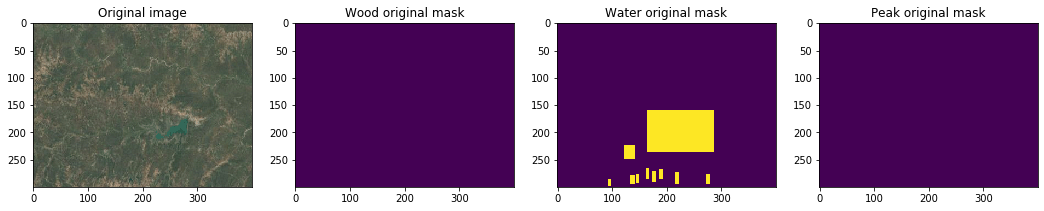

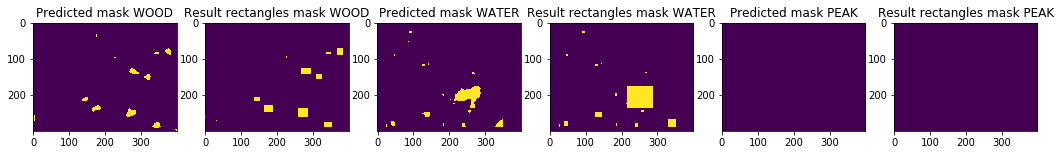

CPU times: user 20.4 s, sys: 60.2 ms, total: 20.5 s
Wall time: 19.8 s


In [355]:
%%time
full_test(interesting_one[5])

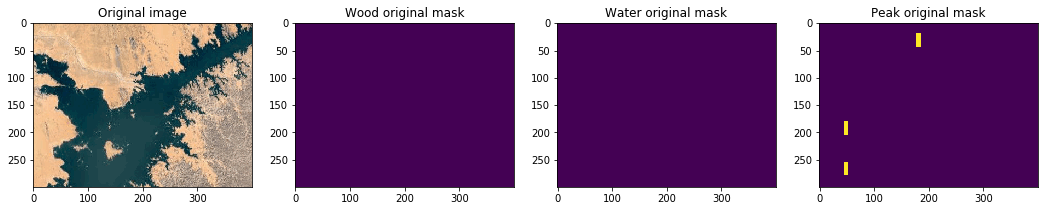

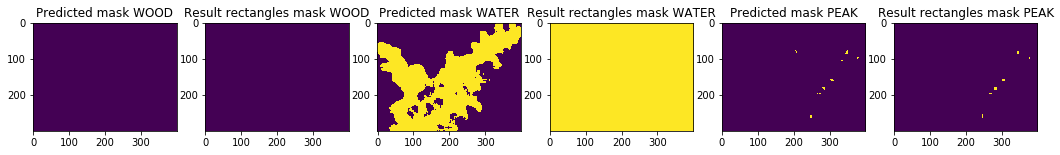

CPU times: user 22.7 s, sys: 132 ms, total: 22.8 s
Wall time: 22.2 s


In [356]:
%%time
full_test(interesting_one[6])